In [2]:
# COMPILAR DESDE GOOGLE COLAB
"""from google.colab import files
import pandas as pd

print("Selecciona archivo deptos_out.csv")
up = files.upload()
csv_path = list(up.keys())[0]


df = pd.read_csv(csv_path, encoding="utf-8-sig")"""


#COMPILAR DESDE LOCAL (EXTENSIÓN JUPYTER VSCODE)
import pandas as pd

# Cargar directamente desde la ruta local
df_basico = pd.read_csv('propiedades_portal_inmobiliario.csv', encoding='utf-8-sig')
df_detalle = pd.read_csv('propiedades_detalle_caracteristicas.csv', encoding='utf-8-sig')

# Merge por el link
df = pd.merge(df_basico, df_detalle, on='link', how='left')

# FIX: Asegurar que existe la columna 'comuna_extraida' si no viene en el CSV
if 'comuna_extraida' not in df.columns:
    print("⚠️ Columna 'comuna_extraida' no encontrada. Se inicializará como 'No Especificada'.")
    df['comuna_extraida'] = 'No Especificada'

print(f"Filas, Columnas: {df.shape}")
display(df.head(10))

⚠️ Columna 'comuna_extraida' no encontrada. Se inicializará como 'No Especificada'.
Filas, Columnas: (2016, 9)


,link,titulo,precio,moneda,superficie_util,superficie_total,dormitorios,banos,comuna_extraida
0,https://portalinmobiliario.com/MLC-2937998712-...,Departamento Amoblado - Espoz,81,UF,220 m²,260 m²,3,3,No Especificada
1,https://portalinmobiliario.com/MLC-3060993802-...,Santa Teresita,79,UF,245 m²,275 m²,3,4,No Especificada
2,https://portalinmobiliario.com/MLC-1684873563-...,"Departamento En Arriendo En San Damián, Sector...",1300000,$,70 m²,80 m²,2,2,No Especificada
3,https://portalinmobiliario.com/MLC-2986729402-...,Moderno Departamento En Arriendo El Golf,34,UF,70 m²,100 m²,1,2,No Especificada
4,https://portalinmobiliario.com/MLC-3152851514-...,Av. Santa Maria - Capellán Abazúa,950000,$,108 m²,108 m²,4,2,No Especificada
5,https://portalinmobiliario.com/MLC-1683529617-...,Departamento Mario Kreutzberger Id: 89490,335000,$,28 m²,28 m²,1,1,No Especificada
6,https://portalinmobiliario.com/MLC-2909038572-...,Aeropuerto,425000,$,70 m²,77 m²,3,2,No Especificada
7,https://portalinmobiliario.com/MLC-1676555479-...,Departamento Zañartu Id: 24728,390000,$,33 m²,36 m²,1,1,No Especificada
8,https://portalinmobiliario.com/MLC-1710244033-...,Departamento En Arriendo En Las Condes,9000,US$,360 m²,500 m²,4,5,No Especificada
9,https://portalinmobiliario.com/MLC-1711467089-...,Departamento En Arriendo De 3 Dorm. En Las Condes,65,UF,250 m²,337 m²,3,4,No Especificada


In [8]:
import pandas as pd

cols_deseadas = ["precio","moneda","superficie_util","superficie_total","dormitorios","banos"]
cols_existentes = [c for c in cols_deseadas if c in df.columns]

df_modelo = df[cols_existentes].copy()

print("Columnas usadas:", cols_existentes)
print("Filas, Columnas:", df_modelo.shape)
display(df_modelo.head(10))

Columnas usadas: ['precio', 'moneda', 'superficie_util', 'superficie_total', 'dormitorios', 'banos']
Filas, Columnas: (2016, 6)


,precio,moneda,superficie_util,superficie_total,dormitorios,banos
0,81,UF,220 m²,260 m²,3,3
1,79,UF,245 m²,275 m²,3,4
2,1300000,$,70 m²,80 m²,2,2
3,34,UF,70 m²,100 m²,1,2
4,950000,$,108 m²,108 m²,4,2
5,335000,$,28 m²,28 m²,1,1
6,425000,$,70 m²,77 m²,3,2
7,390000,$,33 m²,36 m²,1,1
8,9000,US$,360 m²,500 m²,4,5
9,65,UF,250 m²,337 m²,3,4


In [ ]:
# IMPLEMENTACIÓN DE GEOCODIFICACIÓN MEJORADA CON PERSISTENCIA Y LÓGICA "EDIFICIO" + METRO FIX
print("\n=== INICIANDO GEOCODIFICACIÓN AVANZADA (CON PERSISTENCIA Y METROS) ===")

import os
import csv
import time
import pandas as pd
import re

# Instalar geopy si no existe
try:
    import geopy
except ImportError:
    import sys
    !{sys.executable} -m pip install geopy
    import geopy

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# Configurar geolocator
geolocator = Nominatim(user_agent="data_science_rm_v15_smart_retry", timeout=10)

# Archivo de caché persistente
CACHE_FILE = 'geocoding_cache.csv'

# 1. CARGAR CACHÉ EXISTENTE
cache_dict = {}

if os.path.exists(CACHE_FILE):
    print(f"✓ Archivo de caché '{CACHE_FILE}' detectado. Cargando datos previos...")
    try:
        df_cache_disk = pd.read_csv(CACHE_FILE)
        
        if 'link' in df_cache_disk.columns:
            # Eliminar duplicados manteniendo el último (el más reciente)
            df_cache_disk = df_cache_disk.drop_duplicates(subset=['link'], keep='last')
            
            for _, row in df_cache_disk.iterrows():
                cache_dict[row['link']] = {
                    'lat': row['lat'],
                    'lon': row['lon'],
                    'comuna_geo': row['comuna_geo'],
                    'query_used': row.get('query_used', '')
                }
            print(f"  -> {len(cache_dict)} registros únicos recuperados del caché.")
        else:
            print("  ⚠️ Formato antiguo detectado. Se recomienda borrar el archivo csv si da problemas.")
            
    except Exception as e:
        print(f"  ⚠️ Error leyendo caché: {e}. Se iniciará uno nuevo.")
else:
    print(f"ℹ️ No existe caché previo. Se creará '{CACHE_FILE}'.")
    with open(CACHE_FILE, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['link', 'lat', 'lon', 'comuna_geo', 'query_used'])

# 2. APLICAR CACHÉ AL DATAFRAME
hits = 0
for idx, row in df.iterrows():
    link = row['link']
    if link in cache_dict:
        data = cache_dict[link]
        df.at[idx, 'comuna_mejorada'] = data['comuna_geo']
        df.at[idx, 'lat'] = data['lat']
        df.at[idx, 'lon'] = data['lon']
        hits += 1

print(f"  -> {hits} registros aplicados al DataFrame actual.")

# --- DEFINICIÓN DE FUNCIONES Y ESTRATEGIAS ---
# (Mismos diccionarios de antes)
barrios_mapping = {
    'el golf': 'Las Condes', 'alcántara': 'Las Condes', 'escuela militar': 'Las Condes',
    'nueva las condes': 'Las Condes', 'san damián': 'Las Condes', 'san carlos de apoquindo': 'Las Condes',
    'manquehue': 'Las Condes', 'santa maría de manquehue': 'Vitacura', 'jardín del este': 'Vitacura',
    'lo curro': 'Vitacura', 'santa teresita': 'Vitacura', 'tabancura': 'Vitacura',
    'barrio italia': 'Providencia', 'bellavista': 'Providencia', 'pedro de valdivia': 'Providencia',
    'los leones': 'Providencia', 'plaza egaña': 'Ñuñoa', 'barrio universitario': 'Santiago',
    'santa isabel': 'Santiago', 'parque almagro': 'Santiago', 'lastarria': 'Santiago',
    'bellas artes': 'Santiago', 'rodrigo de araya': 'Macul', 'martin de solier': 'Santiago',
    'san isidro': 'Santiago', 'santa victoria': 'Santiago', 'eyzaguirre': 'Santiago',
    'blanco encalada': 'Santiago', 'exequiel fernandez': 'Ñuñoa', 'ciudad de los valles': 'Pudahuel',
    'lomas de lo aguirre': 'Pudahuel', 'chicureo': 'Colina', 'chamisero': 'Colina',
    'el llano': 'San Miguel', 'presidente errazuriz': 'Las Condes', 'pocuro': 'Providencia',
    'el bosque': 'Las Condes', 'isidora goyenechea': 'Las Condes', 'suecia': 'Providencia',
    'lyon': 'Providencia', 'holanda': 'Providencia', 'los conquistadores': 'Providencia'
}

calles_importantes = [
    'pudeto', 'kennedy', 'tobalaba', 'bilbao', 
    'vitacura', 'las condes', 'la dehesa', 'gran avenida', 'santa rosa', 
    'san pablo', 'independencia', 'recoleta', 'matta', 'grecian', 
    'consistorial', 'quilin', 'macul', 'vicuña mackenna', 'irarrazaval', 
    'simon bolivar', 'carmen', 'lira', 'portugal', 'curico', 'tarapaca', 
    'eleuterio ramirez', 'condor', 'san francisco', 'nataniel cox', 'san diego', 
    'ahumada', 'huérfanos', 'moneda', 'agustinas', 'cathedral', 'compañía', 'rosas',
    'san ignacio', 'lord cochrane', 'zenteno', 'bulnes', 'tucapel jimenez'
]

estaciones_metro_oficiales = [
    "Plaza de Maipú", "Santiago Bueras", "Del Sol", "Monte Tabor", "Las Parcelas", "Laguna Sur", "Barrancas", "Pudahuel", "San Pablo", "Lo Prado", "Blanqueado", "Gruta de Lourdes", "Quinta Normal", "Cumming", "Santa Ana", "Plaza de Armas", "Bellas Artes", "Baquedano", "Parque Bustamante", "Santa Isabel", "Irarrázaval", "Ñuble", "Rodrigo de Araya", "Carlos Valdovinos", "Camino Agrícola", "San Joaquín", "Pedrero", "Mirador", "Bellavista de La Florida", "Vicente Valdés",
    "La Cisterna", "San Ramón", "Santa Rosa", "La Granja", "Santa Julia", "Vicuña Mackenna",
    "Tobalaba", "Cristóbal Colón", "Francisco Bilbao", "Príncipe de Gales", "Simón Bolívar", "Plaza Egaña", "Los Orientales", "Grecia", "Los Presidentes", "Quilín", "Las Torres", "Macul", "Rojas Magallanes", "Trinidad", "San José de la Estrella", "Los Quillayes", "Elisa Correa", "Hospital Sótero del Río", "Protectora de la Infancia", "Las Mercedes", "Plaza de Puente Alto",
    "Plaza Quilicura", "Lo Cruzat", "Ferrocarril", "Los Libertadores", "Cardenal Caro", "Vivaceta", "Conchalí", "Plaza Chacabuco", "Hospitales", "Puente Cal y Canto", "Universidad de Chile", "Parque Almagro", "Matta", "Monseñor Eyzaguirre", "Ñuñoa", "Chile España", "Villa Frei", "Fernando Castillo Velasco",
    "Vespucio Norte", "Zapadores", "Dorsal", "Einstein", "Cementerios", "Cerro Blanco", "Patronato", "Toesca", "Parque O'Higgins", "Rondizzoni", "Franklin", "El Llano", "San Miguel", "Lo Vial", "Departamental", "Ciudad del Niño", "Lo Ovalle", "El Parrón", "El Bosque", "Observatorio", "Copa Lo Martinez", "Hospital El Pino",
    "Neptuno", "Pajaritos", "Las Rejas", "Ecuador", "San Alberto Hurtado", "Universidad de Santiago", "Estación Central", "Unión Latinoamericana", "República", "Los Héroes", "La Moneda", "Santa Lucía", "Universidad Católica", "Salvador", "Manuel Montt", "Pedro de Valdivia", "Los Leones", "El Golf", "Alcántara", "Escuela Militar", "Manquehue", "Hernando de Magallanes", "Los Dominicos",
    "Cerrillos", "Lo Valledor", "Presidente Pedro Aguirre Cerda", "Biobío", "Estadio Nacional", "Inés de Suárez"
]

metro_coords_fijas = {
    'irarrázaval': (-33.4542, -70.6275, 'Ñuñoa'),
    'plaza egaña': (-33.4514, -70.5694, 'Ñuñoa'),
    'plaza de armas': (-33.4378, -70.6503, 'Santiago'),
    'baquedano': (-33.4367, -70.6344, 'Providencia'),
    'tobalaba': (-33.4175, -70.6019, 'Providencia'),
    'escuela militar': (-33.4144, -70.5831, 'Las Condes'),
    'manquehue': (-33.4067, -70.5719, 'Las Condes'),
    'los leones': (-33.4222, -70.6097, 'Providencia'),
    'santa isabel': (-33.4467, -70.6333, 'Providencia'),
    'santa ana': (-33.4392, -70.6567, 'Santiago'),
    'san miguel': (-33.4917, -70.6500, 'San Miguel'),
    'el llano': (-33.4833, -70.6500, 'San Miguel'),
    'lo vial': (-33.5000, -70.6500, 'San Miguel'),
    'franklin': (-33.4750, -70.6500, 'Santiago'),
    'rondizzoni': (-33.4667, -70.6500, 'Santiago'),
    'parque o\'higgins': (-33.4633, -70.6583, 'Santiago'),
    'universidad de chile': (-33.4439, -70.6508, 'Santiago'),
    'santa lucía': (-33.4417, -70.6450, 'Santiago'),
    'universidad católica': (-33.4400, -70.6400, 'Santiago'),
    'salvador': (-33.4383, -70.6250, 'Providencia'),
    'manuel montt': (-33.4300, -70.6200, 'Providencia'),
    'pedro de valdivia': (-33.4250, -70.6117, 'Providencia'),
    'los héroes': (-33.4456, -70.6600, 'Santiago'),
    'república': (-33.4483, -70.6683, 'Santiago'),
    'estación central': (-33.4517, -70.6783, 'Estación Central'),
    'universidad de santiago': (-33.4533, -70.6867, 'Estación Central'),
    'san alberto hurtado': (-33.4550, -70.6950, 'Estación Central'),
    'ecuador': (-33.4567, -70.7033, 'Estación Central'),
    'las rejas': (-33.4583, -70.7117, 'Estación Central'),
    'pajaritos': (-33.4567, -70.7250, 'Lo Prado'),
    'neptuno': (-33.4533, -70.7333, 'Lo Prado'),
    'san pablo': (-33.4450, -70.7400, 'Lo Prado'),
    'pudahuel': (-33.4433, -70.7567, 'Pudahuel'),
    'barrancas': (-33.4467, -70.7700, 'Pudahuel'),
    'laguna sur': (-33.4533, -70.7833, 'Pudahuel'),
    'las parcelas': (-33.4600, -70.7967, 'Maipú'),
    'monte tabor': (-33.4667, -70.8100, 'Maipú'),
    'del sol': (-33.4733, -70.8233, 'Maipú'),
    'santiago bueras': (-33.4867, -70.8367, 'Maipú'),
    'plaza de maipú': (-33.5100, -70.7567, 'Maipú'),
    'vicente valdés': (-33.5333, -70.5967, 'La Florida'),
    'bellavista de la florida': (-33.5250, -70.5983, 'La Florida'),
    'mirador': (-33.5167, -70.6000, 'La Florida'),
    'pedrero': (-33.5083, -70.6017, 'Macul'),
    'san joaquín': (-33.5000, -70.6033, 'San Joaquín'),
    'camino agrícola': (-33.4917, -70.6050, 'San Joaquín'),
    'carlos valdovinos': (-33.4833, -70.6067, 'San Joaquín'),
    'rodrigo de araya': (-33.4750, -70.6083, 'San Joaquín'),
    'ñuble': (-33.4667, -70.6100, 'Ñuñoa'),
    'parque bustamante': (-33.4417, -70.6317, 'Providencia'),
    'bellas artes': (-33.4367, -70.6433, 'Santiago'),
    'cumming': (-33.4383, -70.6650, 'Santiago'),
    'quinta normal': (-33.4417, -70.6800, 'Quinta Normal'),
    'gruta de lourdes': (-33.4400, -70.6933, 'Quinta Normal'),
    'blanqueado': (-33.4383, -70.7067, 'Quinta Normal'),
    'lo prado': (-33.4433, -70.7200, 'Lo Prado'),
    'vicuña mackenna': (-33.5333, -70.5967, 'La Florida'),
    'macul': (-33.5083, -70.5967, 'Macul'),
    'las torres': (-33.4917, -70.5967, 'Macul'),
    'quilín': (-33.4833, -70.5967, 'Peñalolén'),
    'los presidentes': (-33.4750, -70.5967, 'Peñalolén'),
    'grecia': (-33.4667, -70.5967, 'Peñalolén'),
    'los orientales': (-33.4583, -70.5967, 'Ñuñoa'),
    'simón bolívar': (-33.4467, -70.5833, 'La Reina'),
    'príncipe de gales': (-33.4383, -70.5833, 'La Reina'),
    'francisco bilbao': (-33.4300, -70.5833, 'Providencia'),
    'cristóbal colón': (-33.4217, -70.5917, 'Providencia'),
    'inés de suárez': (-33.4383, -70.6050, 'Providencia'),
    'estadio nacional': (-33.4617, -70.6083, 'Ñuñoa'),
    'ñuñoa': (-33.4533, -70.6033, 'Ñuñoa'),
    'chile españa': (-33.4533, -70.5967, 'Ñuñoa'),
    'villa frei': (-33.4533, -70.5833, 'Ñuñoa'),
    'fernando castillo velasco': (-33.4533, -70.5667, 'La Reina'),
    'monseñor eyzaguirre': (-33.4533, -70.6167, 'Ñuñoa'),
    'matta': (-33.4617, -70.6300, 'Santiago'),
    'parque almagro': (-33.4533, -70.6517, 'Santiago'),
    'puente cal y canto': (-33.4333, -70.6533, 'Santiago'),
    'hospitales': (-33.4217, -70.6533, 'Independencia'),
    'plaza chacabuco': (-33.4100, -70.6533, 'Independencia'),
    'conchalí': (-33.3983, -70.6533, 'Conchalí'),
    'vivaceta': (-33.3867, -70.6533, 'Conchalí'),
    'cardenal caro': (-33.3750, -70.6533, 'Conchalí'),
    'los libertadores': (-33.3633, -70.6533, 'Quilicura'),
    'ferrocarril': (-33.3517, -70.6533, 'Quilicura'),
    'lo cruzat': (-33.3400, -70.6533, 'Quilicura'),
    'plaza quilicura': (-33.3283, -70.6533, 'Quilicura'),
    'cerrillos': (-33.5000, -70.7167, 'Cerrillos'),
    'lo valledor': (-33.4833, -70.6833, 'Pedro Aguirre Cerda'),
    'presidente pedro aguirre cerda': (-33.4750, -70.6667, 'Pedro Aguirre Cerda'),
    'biobío': (-33.4750, -70.6500, 'San Miguel'),
    'la cisterna': (-33.5333, -70.6667, 'La Cisterna'),
    'el bosque': (-33.5500, -70.6667, 'El Bosque'),
    'observatorio': (-33.5667, -70.6667, 'El Bosque'),
    'copa lo martinez': (-33.5833, -70.6667, 'El Bosque'),
    'hospital el pino': (-33.6000, -70.6667, 'San Bernardo'),
    'vespucio norte': (-33.3667, -70.6333, 'Recoleta'),
    'zapadores': (-33.3833, -70.6333, 'Recoleta'),
    'dorsal': (-33.4000, -70.6333, 'Recoleta'),
    'einstein': (-33.4167, -70.6333, 'Recoleta'),
    'cementerios': (-33.4250, -70.6417, 'Recoleta'),
    'cerro blanco': (-33.4333, -70.6417, 'Recoleta'),
    'patronato': (-33.4333, -70.6500, 'Recoleta'),
    'toesca': (-33.4500, -70.6583, 'Santiago'),
    'ciudad del niño': (-33.5167, -70.6500, 'San Miguel'),
    'lo ovalle': (-33.5333, -70.6500, 'La Cisterna'),
    'el parrón': (-33.5500, -70.6500, 'La Cisterna'),
    'santa julia': (-33.5333, -70.6167, 'La Florida'),
    'la granja': (-33.5333, -70.6333, 'La Granja'),
    'santa rosa': (-33.5333, -70.6500, 'San Ramón'),
    'san ramón': (-33.5500, -70.6500, 'San Ramón'),
    'rojas magallanes': (-33.5500, -70.5967, 'La Florida'),
    'trinidad': (-33.5667, -70.5967, 'La Florida'),
    'san josé de la estrella': (-33.5833, -70.5967, 'La Florida'),
    'los quillayes': (-33.6000, -70.5967, 'La Florida'),
    'elisa correa': (-33.6167, -70.5967, 'Puente Alto'),
    'hospital sótero del río': (-33.6333, -70.5967, 'Puente Alto'),
    'protectora de la infancia': (-33.6500, -70.5967, 'Puente Alto'),
    'las mercedes': (-33.6667, -70.5967, 'Puente Alto'),
    'plaza de puente alto': (-33.6833, -70.5967, 'Puente Alto')
}

comunas_centroids = {
    'Santiago': (-33.4372, -70.6506), 'Providencia': (-33.4372, -70.6106),
    'Las Condes': (-33.4166, -70.5833), 'Vitacura': (-33.3833, -70.5833),
    'Ñuñoa': (-33.4569, -70.5978), 'La Reina': (-33.4500, -70.5333),
    'Lo Barnechea': (-33.3500, -70.5167), 'Peñalolén': (-33.4969, -70.5167),
    'Macul': (-33.4914, -70.5978), 'La Florida': (-33.5242, -70.5989),
    'Estación Central': (-33.4667, -70.6833), 'Independencia': (-33.4167, -70.6667),
    'Recoleta': (-33.4167, -70.6333), 'San Miguel': (-33.4969, -70.6533),
    'San Joaquín': (-33.4969, -70.6322), 'La Cisterna': (-33.5333, -70.6667),
    'La Granja': (-33.5333, -70.6167), 'San Ramón': (-33.5394, -70.6458),
    'La Pintana': (-33.5833, -70.6333), 'San Bernardo': (-33.5925, -70.7000),
    'Puente Alto': (-33.6167, -70.5833), 'Maipú': (-33.5108, -70.7578),
    'Pudahuel': (-33.4403, -70.7500), 'Quilicura': (-33.3611, -70.7306),
    'Huechuraba': (-33.3667, -70.6333), 'Conchalí': (-33.3833, -70.6667),
    'Renca': (-33.4000, -70.7167), 'Quinta Normal': (-33.4333, -70.7000),
    'Lo Prado': (-33.4500, -70.7333), 'Cerro Navia': (-33.4167, -70.7333),
    'Cerrillos': (-33.4972, -70.7167), 'Pedro Aguirre Cerda': (-33.4833, -70.6833),
    'Lo Espejo': (-33.5167, -70.6833), 'El Bosque': (-33.5667, -70.6667)
}

def get_nearest_comuna(lat, lon):
    if pd.isna(lat) or pd.isna(lon): return 'No Especificada'
    min_dist = float('inf')
    nearest = 'No Especificada'
    for comuna, (c_lat, c_lon) in comunas_centroids.items():
        dist = (lat - c_lat)**2 + (lon - c_lon)**2
        if dist < min_dist:
            min_dist, nearest = dist, comuna
    return nearest

def expandir_abreviaciones(texto):
    reemplazos = {
        r'\bsta\.': 'santa', r'\bsto\.': 'santo', r'\bav\.': 'avenida',
        r'\balmte\.': 'almirante', r'\bgral\.': 'general', r'\bpte\.': 'presidente',
        r'\bdr\.': 'doctor', r'\bprof\.': 'profesor', r'\bpje\.': 'pasaje'
    }
    for patron, reemplazo in reemplazos.items():
        texto = re.sub(patron, reemplazo, texto)
    return texto

def limpiar_nombre_calle(nombre):
    nombre = re.sub(r'\s+(id|cod|ref|cód)[:\.]?\s*\d+.*$', '', nombre, flags=re.IGNORECASE)
    nombre = re.sub(r'\s+(id|cod|ref|cód)[:\.]?$', '', nombre, flags=re.IGNORECASE)
    
    cortar_en = [' vista ', ' piso ', ' torre ', ' depto', ' departamento', ' edificio', 
                 ' esquina', ' (', ' norte', ' sur', ' oriente', ' poniente', 
                 ' interior', ' sector', ' cercano', ' a pasos', ' frente', ' con ', ' sin ',
                 ' salida', ' entrada', ' metro', ' estación']
    
    nombre_limpio = nombre
    for corte in cortar_en:
        if corte in nombre_limpio:
            nombre_limpio = nombre_limpio.split(corte)[0]
    
    return nombre_limpio.strip()

def geocode_full_process(row):
    titulo_original = str(row.get('titulo', ''))
    titulo_lower = titulo_original.lower()
    titulo_expandido = expandir_abreviaciones(titulo_lower)
    
    print(f"Procesando: '{titulo_original[:40]}...'")
    
    queries_to_try = []
    
    # 1. Mapeo directo por barrio
    for barrio, comuna in barrios_mapping.items():
        if barrio in titulo_expandido:
            print(f"  ✓ Barrio/Calle clave detectada: '{barrio}' -> {comuna}")
            try:
                loc = geolocator.geocode(f"{barrio}, Santiago, Chile")
                if loc: 
                    return (loc.latitude, loc.longitude, comuna, f"Barrio: {barrio}")
            except: pass
            # Si encontramos el barrio pero falló la API, igual asignamos la comuna
            return (None, None, comuna, f"Barrio: {barrio}")

    # 2. Estrategia "Calles Importantes"
    for calle in calles_importantes:
        if calle in titulo_expandido:
            print(f"  🛣️ Calle Importante detectada: '{calle}'")
            queries_to_try.append(f"Calle {calle}, Santiago, Chile")
            queries_to_try.append(f"Avenida {calle}, Santiago, Chile")
            break 

    # 3. Estrategia "Metro"
    if "metro" in titulo_expandido:
        match = re.search(r'metro\s+([a-zá-úñ\s]+)', titulo_expandido)
        if match:
            nombre_metro = match.group(1).strip()
            nombre_metro = re.sub(r'\s+(l\d+|linea|línea)\b.*$', '', nombre_metro)
            nombre_metro = re.sub(r'\s+[a-z]$', '', nombre_metro)
            nombre_metro = limpiar_nombre_calle(nombre_metro)
            
            mejor_match = None
            for estacion in estaciones_metro_oficiales:
                if estacion.lower() in nombre_metro:
                    mejor_match = estacion
                    break
            
            if mejor_match:
                print(f"  🚇 Detectado Metro (Oficial): '{mejor_match}'")
                if mejor_match.lower() in metro_coords_fijas:
                     lat_f, lon_f, com_f = metro_coords_fijas[mejor_match.lower()]
                     print(f"    -> Coordenadas fijas encontradas: {com_f}")
                     return (lat_f, lon_f, com_f, f"Metro Fijo: {mejor_match}")
                else:
                     queries_to_try.append(f"Estación Metro {mejor_match}, Santiago, Chile")
            elif len(nombre_metro) > 3:
                print(f"  🚇 Detectado Metro (Genérico): '{nombre_metro}'")
                queries_to_try.append(f"Estación Metro {nombre_metro}, Santiago, Chile")

    # 4. Estrategia "Avenida/Calle" explícita
    match_calle = re.search(r'(avenida|calle|paseo|camino|costanera|autopista|pasaje)\s+([a-zá-úñ\s\.]+)', titulo_expandido)
    if match_calle:
        tipo = match_calle.group(1)
        nombre = match_calle.group(2).strip()
        nombre = limpiar_nombre_calle(nombre)
        
        full_calle = f"{tipo} {nombre}"
        if len(nombre) > 2:
            print(f"  🛣️ Detectada Calle: '{full_calle}'")
            queries_to_try.append(f"{full_calle}, Santiago, Chile")

    # 5. Estrategia "Condominio/Edificio"
    match_edificio = re.search(r'(edificio|condominio)\s+([a-zá-úñ\s]+)', titulo_expandido)
    if match_edificio:
        tipo = match_edificio.group(1)
        nombre = match_edificio.group(2).strip()
        nombre = re.sub(r'\s(en|con|de|el|la|los|las)$', '', nombre)
        nombre = limpiar_nombre_calle(nombre)
        
        if not re.match(r'(avenida|calle)', nombre):
            if len(nombre) > 3:
                print(f"  🏢 Detectado {tipo.title()}: '{nombre}'")
                queries_to_try.append(f"{nombre}, Santiago, Chile")
                queries_to_try.append(f"Calle {nombre}, Santiago, Chile")

    # 6. Estrategia "Cerca de / A pasos de"
    match_cerca = re.search(r'(cerca de|a pasos de|frente a)\s+([a-zá-úñ\s]+)', titulo_expandido)
    if match_cerca:
        nombre_ref = match_cerca.group(2).strip()
        nombre_ref = limpiar_nombre_calle(nombre_ref)
        if len(nombre_ref) > 3:
            print(f"  📍 Detectada Referencia: '{nombre_ref}'")
            queries_to_try.append(f"{nombre_ref}, Santiago, Chile")

    # 7. Estrategia Título Limpio (Fallback)
    if not queries_to_try:
        titulo_limpio = limpiar_nombre_calle(titulo_original.lower())
        if len(titulo_limpio) >= 4:
             queries_to_try.append(f"{titulo_limpio}, Santiago, Chile")

    # Ejecutar intentos
    seen_queries = set()
    unique_queries = []
    for q in queries_to_try:
        if q not in seen_queries:
            unique_queries.append(q)
            seen_queries.add(q)

    for query in unique_queries:
        try:
            location = geolocator.geocode(query)
            if location:
                lat, lon = location.latitude, location.longitude
                print(f"  ✓ Encontrado con: '{query}' -> {lat:.4f}, {lon:.4f}")
                
                reverse = geolocator.reverse((lat, lon), language='es')
                comuna_norm = 'No Especificada'
                
                if reverse and reverse.raw.get('address'):
                    addr = reverse.raw['address']
                    comuna_raw = (addr.get('suburb') or addr.get('city_district') or 
                                  addr.get('municipality') or addr.get('town') or addr.get('city'))
                    if comuna_raw:
                        comuna_norm = comuna_raw.title()
                        if comuna_norm == 'Santiago De Chile': comuna_norm = 'Santiago'
                
                if comuna_norm in ['Provincia De Santiago', 'Santiago De Chile', 'Region Metropolitana', 'No Especificada', None]:
                    comuna_norm = get_nearest_comuna(lat, lon)
                    print(f"  ✓ Asignado por cercanía: {comuna_norm}")
                else:
                    print(f"  ✓ Asignado por API: {comuna_norm}")
                    
                return (lat, lon, comuna_norm, query)
                
        except (GeocoderTimedOut, GeocoderServiceError):
            time.sleep(1)
        except Exception as e:
            print(f"  ❌ Error: {e}")
            
    print("  ❌ No encontrado")
    return (None, None, 'No Especificada', 'Failed')

# Filtrar registros pendientes con LÓGICA INTELIGENTE
indices_pendientes = []

print("\nAnalizando registros pendientes...")
for idx, row in df.iterrows():
    link = row['link']
    
    # Si ya tiene comuna válida, saltar
    if df.at[idx, 'comuna_mejorada'] != 'No Especificada' and pd.notna(df.at[idx, 'comuna_mejorada']):
        continue
        
    # Si NO está en caché, procesar (es nuevo o se perdió)
    if link not in cache_dict:
        indices_pendientes.append(idx)
        continue
        
    # Si ESTÁ en caché pero falló ('No Especificada'), aplicar filtro inteligente
    if cache_dict[link]['comuna_geo'] == 'No Especificada':
        titulo = str(row.get('titulo', '')).lower()
        # Solo reintentar si tiene palabras clave que podrían funcionar con la nueva lógica
        if any(kw in titulo for kw in ['metro', 'edificio', 'condominio', 'calle', 'avenida']):
            indices_pendientes.append(idx)
        # Si no tiene palabras clave, asumimos que seguirá fallando y NO lo agregamos

registros_pendientes = df.loc[indices_pendientes]
total_pendientes = len(registros_pendientes)
print(f"Total registros a procesar (nuevos + reintentos inteligentes): {total_pendientes}")

if total_pendientes > 0:
    print("Iniciando procesamiento...")
    
    with open(CACHE_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        
        for i, (idx, row) in enumerate(registros_pendientes.iterrows()):
            print(f"[{i+1}/{total_pendientes}] (ID: {idx}) ", end="")
            
            lat, lon, comuna, query_used = geocode_full_process(row)
            
            writer.writerow([row['link'], lat, lon, comuna, query_used])
            f.flush()
            
            df.at[idx, 'comuna_mejorada'] = comuna
            df.at[idx, 'lat'] = lat
            df.at[idx, 'lon'] = lon

    print(f"\n✓ Proceso finalizado. Datos guardados en '{CACHE_FILE}'")
else:
    print("✓ No hay registros pendientes de mejora.")

# Consolidar columna final
if 'comuna_mejorada' in df.columns:
    df['comuna_final'] = df['comuna_mejorada'].fillna(df['comuna_extraida'])
else:
    df['comuna_final'] = df['comuna_extraida']

df['comuna_final'] = df['comuna_final'].replace({'no especificada': 'No Especificada', 'No especificada': 'No Especificada'})

print(f"\n=== RESULTADO FINAL ===")
props_mejorada = df['comuna_final'].value_counts()
print(f"Comunas identificadas: {(props_mejorada.index != 'No Especificada').sum()}")
print(f"Sin comuna: {props_mejorada.get('No Especificada', 0)} ({props_mejorada.get('No Especificada', 0)/len(df)*100:.1f}%)")

print("\nTop 10 comunas:")
for comuna, count in props_mejorada.head(10).items():
    pct = count/len(df)*100
    rep = "✓" if count >= 30 else "⚠️"
    print(f"{rep} {comuna:22} {count:4} props ({pct:5.1f}%)")


=== INICIANDO GEOCODIFICACIÓN AVANZADA (CON PERSISTENCIA Y METROS) ===
✓ Archivo de caché 'geocoding_cache.csv' detectado. Cargando datos previos...
  -> 770 registros únicos recuperados del caché (por Link).
  -> 770 registros aplicados al DataFrame actual.

Total registros a procesar (nuevos + reintentos): 1744
Iniciando procesamiento...
[1/1744] (ID: 0) Procesando: 'Departamento Amoblado - Espoz...'
✓ Archivo de caché 'geocoding_cache.csv' detectado. Cargando datos previos...
  -> 770 registros únicos recuperados del caché (por Link).
  -> 770 registros aplicados al DataFrame actual.

Total registros a procesar (nuevos + reintentos): 1744
Iniciando procesamiento...
[1/1744] (ID: 0) Procesando: 'Departamento Amoblado - Espoz...'
  ❌ No encontrado
[2/1744] (ID: 1) Procesando: 'Santa Teresita...'
  ✓ Barrio/Calle clave detectada: 'santa teresita' -> Vitacura
  ❌ No encontrado
[2/1744] (ID: 1) Procesando: 'Santa Teresita...'
  ✓ Barrio/Calle clave detectada: 'santa teresita' -> Vitacur

KeyboardInterrupt: 

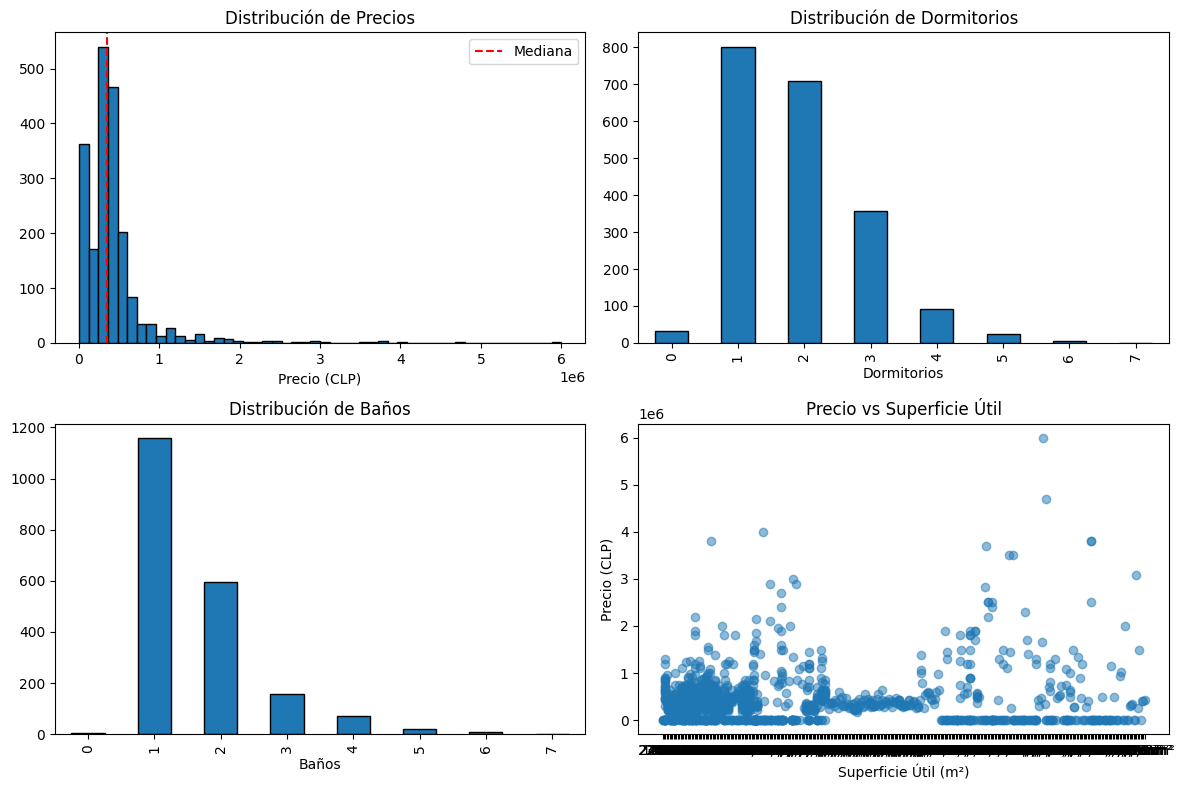

✓ Análisis exploratorio completado


In [26]:
# Visualización de distribuciones
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Precio
axes[0,0].hist(df_modelo['precio'], bins=50, edgecolor='black')
axes[0,0].set_title('Distribución de Precios')
axes[0,0].set_xlabel('Precio (CLP)')
axes[0,0].axvline(df_modelo['precio'].median(), color='red', linestyle='--', label='Mediana')
axes[0,0].legend()

# Dormitorios
df_modelo['dormitorios'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], edgecolor='black')
axes[0,1].set_title('Distribución de Dormitorios')
axes[0,1].set_xlabel('Dormitorios')

# Baños
df_modelo['banos'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Distribución de Baños')
axes[1,0].set_xlabel('Baños')

# Scatter precio vs superficie
axes[1,1].scatter(df_modelo['superficie_util'], df_modelo['precio'], alpha=0.5)
axes[1,1].set_title('Precio vs Superficie Útil')
axes[1,1].set_xlabel('Superficie Útil (m²)')
axes[1,1].set_ylabel('Precio (CLP)')

plt.tight_layout()
plt.show()

print("✓ Análisis exploratorio completado")

In [27]:
# VALIDACIÓN DE GEOCODIFICACIÓN
# (El proceso de geocodificación ya se realizó en la celda anterior usando caché persistente)

print("=== ESTADO DE GEOCODIFICACIÓN ===")
if 'comuna_final' in df.columns:
    total = len(df)
    con_comuna = (df['comuna_final'] != 'No Especificada').sum()
    con_coords = df[['lat', 'lon']].notna().all(axis=1).sum()
    
    print(f"Total registros: {total}")
    print(f"Con comuna identificada: {con_comuna} ({con_comuna/total*100:.1f}%)")
    print(f"Con coordenadas (lat/lon): {con_coords} ({con_coords/total*100:.1f}%)")
    
    # Muestra aleatoria de resultados
    print("\nEjemplos de asignación:")
    cols_mostrar = ['titulo', 'comuna_extraida', 'comuna_final', 'lat', 'lon']
    display(df[cols_mostrar].sample(5))
else:
    print("⚠️ No se detectaron las columnas de geocodificación. Por favor ejecuta la celda anterior.")

=== ESTADO DE GEOCODIFICACIÓN ===
Total registros: 2016
Con comuna identificada: 1678 (83.2%)
Con coordenadas (lat/lon): 1228 (60.9%)

Ejemplos de asignación:


,titulo,comuna_extraida,comuna_final,lat,lon
121,"Oportunidad! 46 M2 , 2d 2b, Uno En Suite, Metro",No especificada,No Especificada,NaN,NaN
1699,Departamento Zañartu Id: 158092,No especificada,Santiago,-33.439341,-70.658369
366,1d+1b En Nueva Independencia - Privacidad Y Conectividad,Independencia,Independencia,NaN,NaN
221,"Amoblado Full! Arriendo Depto 2d 2b Estoril, Las Condes",Las Condes,Las Condes,NaN,NaN
305,Nuevo Dpto 2d 2b | Semi Amoblado,No especificada,No Especificada,NaN,NaN


In [28]:
# Obtener valor UF histórico y enriquecer datos
import requests
from datetime import datetime

# API para obtener UF
def obtener_valor_uf():
    try:
        url = "https://mindicador.cl/api/uf"
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            data = response.json()
            return data['serie'][0]['valor']
        else:
            return 38000  # valor aproximado fallback
    except:
        return 38000

valor_uf = obtener_valor_uf()
print(f"Valor UF actual: ${valor_uf:,.2f} CLP")

# Agregar valor UF al dataframe para conversión posterior
df['valor_uf_referencia'] = valor_uf

Valor UF actual: $39,643.59 CLP


In [31]:
# PREPROCESAMIENTO: FILTRADO DE MONEDA, CONVERSIÓN UF Y LIMPIEZA DE SUPERFICIES
import re
import numpy as np

# 1. Filtrar moneda y convertir a UF
df_pesos = df_modelo.copy()
df_pesos["moneda_norm"] = df_pesos["moneda"].astype(str).str.strip()

# Filtrar solo pesos chilenos
df_pesos = df_pesos[df_pesos["moneda_norm"] == "$"].drop(columns=["moneda_norm"])

# Convertir precio a UF (variable más estable en el tiempo)
df_pesos['precio_uf'] = df_pesos['precio'] / valor_uf

print("=== FILTRADO Y CONVERSIÓN ===")
print("Filas, Columnas (solo $):", df_pesos.shape)
print(f"Precio promedio: ${df_pesos['precio'].mean():,.0f} CLP ({df_pesos['precio_uf'].mean():.2f} UF)")

# 2. Limpieza de superficies (m2)
def to_m2_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    s = s.replace("m²", "").replace("m2", "").replace("m^2", "")
    s = s.replace(",", ".")
    nums = re.findall(r"\d*\.?\d+", s)
    if not nums:
        return np.nan
    vals = [float(n) for n in nums if n != ""]
    if not vals:
        return np.nan
    # si hay rango (varios números), usamos el promedio
    return float(np.mean(vals))

for col in ["superficie_util", "superficie_total"]:
    if col in df_pesos.columns:
        df_pesos[col] = df_pesos[col].apply(to_m2_float)

print("\n=== LIMPIEZA DE SUPERFICIES ===")
print("Tipos de datos tras conversión:")
display(df_pesos[['superficie_util', 'superficie_total']].dtypes)

print("\nMuestra final procesada:")
display(df_pesos.head(5))

=== FILTRADO Y CONVERSIÓN ===
Filas, Columnas (solo $): (1653, 7)
Precio promedio: $501,742 CLP (12.66 UF)

=== LIMPIEZA DE SUPERFICIES ===
Tipos de datos tras conversión:


superficie_util     float64
superficie_total    float64
dtype: object


Muestra final procesada:


,precio,moneda,superficie_util,superficie_total,dormitorios,banos,precio_uf
2,1300000,$,70.0,80.0,2,2,32.792187
4,950000,$,108.0,108.0,4,2,23.963521
5,335000,$,28.0,28.0,1,1,8.450294
6,425000,$,70.0,77.0,3,2,10.720523
7,390000,$,33.0,36.0,1,1,9.837656


In [ ]:
# PREPARACIÓN DE DATOS Y CONFIGURACIÓN DEL MODELO
# 1. Imports necesarios
!pip -q install scikit-learn
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Preparación del Dataset Base
df_arriendo = df_pesos.copy()

# Asegurar tipos numéricos
for col in ["dormitorios", "banos", "precio", "precio_uf"]:
    if col in df_arriendo.columns:
        df_arriendo[col] = pd.to_numeric(df_arriendo[col], errors="coerce")

# Completar superficies con ratio mediana
if {"superficie_util","superficie_total"}.issubset(df_arriendo.columns):
    ambos = df_arriendo[["superficie_util","superficie_total"]].dropna()
    ratio_mediana = (ambos["superficie_total"] / ambos["superficie_util"]).clip(0.6, 2.5).median() if len(ambos) >= 30 else 1.15
    m_util_nan = df_arriendo["superficie_util"].isna() & df_arriendo["superficie_total"].notna()
    df_arriendo.loc[m_util_nan, "superficie_util"] = df_arriendo.loc[m_util_nan, "superficie_total"] / ratio_mediana
    m_tot_nan  = df_arriendo["superficie_total"].isna() & df_arriendo["superficie_util"].notna()
    df_arriendo.loc[m_tot_nan,  "superficie_total"] = df_arriendo.loc[m_tot_nan,  "superficie_util"] * ratio_mediana

# 3. Integración de Geolocalización y Relleno de Coordenadas
cols_geo = ['comuna_final', 'lat', 'lon']
for col in cols_geo:
    if col in df.columns:
        df_arriendo[col] = df[col]

if 'comuna_final' in df_arriendo.columns:
    df_arriendo['comuna'] = df_arriendo['comuna_final']
else:
    df_arriendo['comuna'] = 'No Especificada'

# Rellenar coordenadas faltantes usando centroides (comunas_centroids de celda 4)
sin_coords = df_arriendo[['lat', 'lon']].isna().any(axis=1)
if sin_coords.sum() > 0:
    print(f"⚠️ {sin_coords.sum()} registros sin coordenadas. Imputando con centroides...")
    for idx in df_arriendo[sin_coords].index:
        comuna = df_arriendo.loc[idx, 'comuna']
        if pd.notna(comuna) and comuna in comunas_centroids:
            lat, lon = comunas_centroids[comuna]
            df_arriendo.loc[idx, 'lat'] = lat
            df_arriendo.loc[idx, 'lon'] = lon

# 4. Feature Engineering: Distancia al Metro
# Estaciones de metro de Santiago (coordenadas reales - Líneas 1-6)
estaciones_metro = [
    (-33.4450, -70.7167), (-33.4447, -70.7000), (-33.4397, -70.6833), (-33.4386, -70.6753), (-33.4375, -70.6667),
    (-33.4408, -70.6569), (-33.4456, -70.6506), (-33.4492, -70.6483), (-33.4528, -70.6461), (-33.4456, -70.6419),
    (-33.4428, -70.6333), (-33.4372, -70.6300), (-33.4375, -70.6250), (-33.4389, -70.6197), (-33.4400, -70.6144),
    (-33.4489, -70.6093), (-33.4550, -70.6028), (-33.4372, -70.6106), (-33.4336, -70.6044), (-33.4306, -70.5986),
    (-33.4167, -70.5917), (-33.4122, -70.5861), (-33.4083, -70.5806), (-33.4166, -70.6000), (-33.4042, -70.5694),
    (-33.3997, -70.5625), (-33.3928, -70.5547), (-33.3683, -70.6553), (-33.3867, -70.6553), (-33.3972, -70.6553),
    (-33.4072, -70.6553), (-33.4133, -70.6553), (-33.4200, -70.6497), (-33.4267, -70.6419), (-33.4361, -70.6408),
    (-33.4400, -70.6378), (-33.4428, -70.6333), (-33.4478, -70.6336), (-33.4547, -70.6336), (-33.4628, -70.6336),
    (-33.4689, -70.6369), (-33.4803, -70.6403), (-33.4903, -70.6458), (-33.4969, -70.6533), (-33.5050, -70.6594),
    (-33.5131, -70.6658), (-33.5214, -70.6722), (-33.5292, -70.6781), (-33.5331, -70.6678), (-33.5447, -70.6594),
    (-33.5531, -70.6508), (-33.5617, -70.6422), (-33.5728, -70.6286), (-33.3611, -70.7306), (-33.3694, -70.7194),
    (-33.3808, -70.7056), (-33.3889, -70.6958), (-33.3992, -70.6847), (-33.4083, -70.6742), (-33.4161, -70.6658),
    (-33.4236, -70.6583), (-33.4300, -70.6517), (-33.4361, -70.6408), (-33.4392, -70.6375), (-33.4425, -70.6342),
    (-33.4522, -70.6244), (-33.4600, -70.6167), (-33.4694, -70.6069), (-33.4753, -70.6008), (-33.4569, -70.5978),
    (-33.4828, -70.5931), (-33.4892, -70.5869), (-33.4500, -70.5333), (-33.5006, -70.5747), (-33.4167, -70.5917),
    (-33.4236, -70.5842), (-33.4308, -70.5764), (-33.4500, -70.5333), (-33.4500, -70.5450), (-33.4581, -70.5569),
    (-33.4653, -70.5647), (-33.4969, -70.5167), (-33.4789, -70.5831), (-33.4869, -70.5911), (-33.4914, -70.5978),
    (-33.4989, -70.6050), (-33.5050, -70.6119), (-33.5111, -70.6186), (-33.5175, -70.6253), (-33.5242, -70.5989),
    (-33.5317, -70.6050), (-33.5389, -70.6111), (-33.5461, -70.6172), (-33.5539, -70.6236), (-33.5614, -70.6300),
    (-33.5686, -70.6361), (-33.5989, -70.5758), (-33.6075, -70.5775), (-33.6167, -70.5833), (-33.5111, -70.6186),
    (-33.5197, -70.6258), (-33.5269, -70.6328), (-33.5333, -70.6394), (-33.5394, -70.6458), (-33.5331, -70.6678),
    (-33.5108, -70.7578), (-33.5067, -70.7492), (-33.5025, -70.7408), (-33.4981, -70.7322), (-33.4933, -70.7233),
    (-33.4881, -70.7142), (-33.4403, -70.7500), (-33.4483, -70.7389), (-33.4572, -70.7275), (-33.4669, -70.7158),
    (-33.4756, -70.7044), (-33.4844, -70.6931), (-33.4400, -70.6378), (-33.4392, -70.6375), (-33.4375, -70.6300),
    (-33.4489, -70.6093), (-33.4550, -70.6028), (-33.4639, -70.5939), (-33.4722, -70.5850), (-33.4803, -70.5764),
    (-33.4881, -70.5678), (-33.4958, -70.5594), (-33.5042, -70.5503), (-33.5111, -70.6186), (-33.5194, -70.6203),
    (-33.5275, -70.6219), (-33.5242, -70.5989), (-33.5331, -70.5903), (-33.5419, -70.5817), (-33.5506, -70.5731),
    (-33.4972, -70.7167), (-33.4889, -70.7053), (-33.4806, -70.6939), (-33.4689, -70.6369), (-33.4622, -70.6297),
    (-33.4881, -70.5678), (-33.4728, -70.5772), (-33.4569, -70.5978), (-33.4450, -70.6083), (-33.4306, -70.5986)
]

def calcular_distancia_haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1_rad, lat2_rad = np.radians(lat1), np.radians(lat2)
    delta_lat, delta_lon = np.radians(lat2 - lat1), np.radians(lon2 - lon1)
    a = np.sin(delta_lat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def distancia_metro_mas_cercano(lat, lon):
    if pd.isna(lat) or pd.isna(lon): return np.nan
    distancias = [calcular_distancia_haversine(lat, lon, est[0], est[1]) for est in estaciones_metro]
    return min(distancias)

df_arriendo['dist_metro_km'] = df_arriendo.apply(lambda row: distancia_metro_mas_cercano(row['lat'], row['lon']), axis=1)

# 5. Feature Engineering: Datos Socioeconómicos
datos_socioeconomicos = {
    'Providencia': {'poblacion': 142079, 'ingreso_medio': 1800000}, 'Las Condes': {'poblacion': 330759, 'ingreso_medio': 2500000},
    'Vitacura': {'poblacion': 96774, 'ingreso_medio': 3000000}, 'Ñuñoa': {'poblacion': 208237, 'ingreso_medio': 1500000},
    'La Reina': {'poblacion': 100252, 'ingreso_medio': 1700000}, 'Lo Barnechea': {'poblacion': 124076, 'ingreso_medio': 2200000},
    'Peñalolén': {'poblacion': 266798, 'ingreso_medio': 850000}, 'Macul': {'poblacion': 134635, 'ingreso_medio': 950000},
    'La Florida': {'poblacion': 402433, 'ingreso_medio': 900000}, 'Santiago': {'poblacion': 503147, 'ingreso_medio': 800000},
    'Independencia': {'poblacion': 142065, 'ingreso_medio': 750000}, 'Recoleta': {'poblacion': 190075, 'ingreso_medio': 800000},
    'Conchalí': {'poblacion': 139195, 'ingreso_medio': 700000}, 'Huechuraba': {'poblacion': 112528, 'ingreso_medio': 950000},
    'Quinta Normal': {'poblacion': 136368, 'ingreso_medio': 750000}, 'Estación Central': {'poblacion': 206792, 'ingreso_medio': 800000},
    'Cerrillos': {'poblacion': 88956, 'ingreso_medio': 850000}, 'Maipú': {'poblacion': 578605, 'ingreso_medio': 950000},
    'Pudahuel': {'poblacion': 253139, 'ingreso_medio': 750000}, 'Lo Prado': {'poblacion': 104316, 'ingreso_medio': 650000},
    'Renca': {'poblacion': 160847, 'ingreso_medio': 650000}, 'Quilicura': {'poblacion': 254694, 'ingreso_medio': 900000},
    'Cerro Navia': {'poblacion': 142465, 'ingreso_medio': 600000}, 'San Miguel': {'poblacion': 133059, 'ingreso_medio': 900000},
    'La Cisterna': {'poblacion': 100434, 'ingreso_medio': 850000}, 'San Joaquín': {'poblacion': 103485, 'ingreso_medio': 850000},
    'Pedro Aguirre Cerda': {'poblacion': 107803, 'ingreso_medio': 700000}, 'Lo Espejo': {'poblacion': 103865, 'ingreso_medio': 650000},
    'San Ramón': {'poblacion': 92312, 'ingreso_medio': 650000}, 'La Granja': {'poblacion': 122557, 'ingreso_medio': 650000},
    'El Bosque': {'poblacion': 172000, 'ingreso_medio': 650000}, 'La Pintana': {'poblacion': 189335, 'ingreso_medio': 600000},
    'San Bernardo': {'poblacion': 334836, 'ingreso_medio': 750000}, 'Puente Alto': {'poblacion': 645909, 'ingreso_medio': 750000},
    'Colina': {'poblacion': 180353, 'ingreso_medio': 800000}, 'Lampa': {'poblacion': 127281, 'ingreso_medio': 750000},
    'Tiltil': {'poblacion': 20385, 'ingreso_medio': 600000}, 'Curacaví': {'poblacion': 36430, 'ingreso_medio': 650000},
    'María Pinto': {'poblacion': 14926, 'ingreso_medio': 600000}, 'Melipilla': {'poblacion': 141165, 'ingreso_medio': 700000},
    'San Pedro': {'poblacion': 10588, 'ingreso_medio': 550000}, 'Alhué': {'poblacion': 6676, 'ingreso_medio': 500000},
    'Talagante': {'poblacion': 78675, 'ingreso_medio': 750000}, 'El Monte': {'poblacion': 40014, 'ingreso_medio': 650000},
    'Isla de Maipo': {'poblacion': 40171, 'ingreso_medio': 700000}, 'Padre Hurtado': {'poblacion': 75080, 'ingreso_medio': 800000},
    'Peñaflor': {'poblacion': 96729, 'ingreso_medio': 750000}, 'Pirque': {'poblacion': 30433, 'ingreso_medio': 1200000},
    'San José de Maipo': {'poblacion': 18644, 'ingreso_medio': 900000}, 'Buin': {'poblacion': 109641, 'ingreso_medio': 700000},
    'Paine': {'poblacion': 82766, 'ingreso_medio': 650000}, 'Calera de Tango': {'poblacion': 27970, 'ingreso_medio': 700000},
    'Otra': {'poblacion': 150000, 'ingreso_medio': 900000}
}

df_arriendo['poblacion_comuna'] = df_arriendo['comuna'].map(lambda c: datos_socioeconomicos.get(c, {}).get('poblacion', 150000))
df_arriendo['ingreso_medio_comuna'] = df_arriendo['comuna'].map(lambda c: datos_socioeconomicos.get(c, {}).get('ingreso_medio', 900000))

# 6. Definición Final de Features y Target
features = [c for c in ["superficie_util","superficie_total","dormitorios","banos","lat","lon","dist_metro_km","ingreso_medio_comuna","poblacion_comuna"] if c in df_arriendo.columns]
target = "precio_uf"

# Incluir 'comuna' para estratificación
df_trainable = df_arriendo[features + [target] + ['comuna']].copy()
df_trainable = df_trainable[df_trainable[target].notna()]

# === TRATAMIENTO DE COMUNAS 'NO ESPECIFICADA' ===
mask_no_spec = df_trainable['comuna'] == 'No Especificada'
n_no_spec = mask_no_spec.sum()

if n_no_spec > 0:
    print(f"⚠️ Se detectaron {n_no_spec} registros con 'No Especificada'.")
    conteo_comunas = df_trainable.loc[~mask_no_spec, 'comuna'].value_counts(normalize=True)
    comunas_conocidas = conteo_comunas.index
    probabilidades = conteo_comunas.values
    np.random.seed(42)
    comunas_imputadas = np.random.choice(comunas_conocidas, size=n_no_spec, p=probabilidades)
    df_trainable.loc[mask_no_spec, 'comuna'] = comunas_imputadas
    print("   ✓ Imputación de comunas completada.")

# 7. Imputación de valores faltantes (Features numéricas)
imp = SimpleImputer(strategy="median")
X_all = imp.fit_transform(df_trainable[features].values)
y_all = df_trainable[target].values

print("\n=== ESTADO FINAL DEL DATASET PARA MODELO ===")
print("Features usadas:", features)
print("Shape entrenable:", df_trainable.shape)
print(f"Target: {target} (rango: {y_all.min():.2f} - {y_all.max():.2f} UF)")

⚠️ Se detectaron 224 registros con 'No Especificada'.
   -> Aplicando distribución proporcional basada en comunas conocidas...
   ✓ Imputación completada. Los registros se han distribuido.

=== ESTADO DEL DATASET ===
Features usadas: ['superficie_util', 'superficie_total', 'dormitorios', 'banos', 'lat', 'lon']
Shape entrenable: (1653, 8)
Target: precio_uf (rango: 3.78 - 151.35 UF)
Comunas en dataset (post-imputación): 41
✓ Cantidad de datos suficiente para entrenamiento.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


,superficie_util,superficie_total,dormitorios,banos,lat,lon,precio_uf,comuna
2,70.0,80.0,2,2,-33.381141,-70.522101,32.792187,Las Condes
4,108.0,108.0,4,2,-33.432636,-70.648424,23.963521,Recoleta
5,28.0,28.0,1,1,-33.435837,-70.659225,8.450294,Santiago
6,70.0,77.0,3,2,-33.446505,-70.660975,10.720523,Santiago
7,33.0,36.0,1,1,-33.439341,-70.658369,9.837656,Santiago


# VALIDACIÓN ESTRATIFICADA POR COMUNA

## Metodología de Validación

Este proyecto implementa una **validación robusta y estratificada** según las mejores prácticas de Machine Learning:

### 1. División Estratificada Train/Test (75/25)
- **Estratificación por comuna**: Mantiene la proporción de cada comuna en train y test
- **Ratio 75/25**: Balance entre datos de entrenamiento y validación
- **Random state fijo**: Reproducibilidad de resultados

### 2. Cross-Validation Estratificada (5-Fold)
- **K-Fold estratificado**: 5 divisiones manteniendo proporciones por comuna
- **Métricas consistentes**: Validación de robustez del modelo
- **Detección de overfitting**: Comparación R² train vs CV

### 3. Agrupación de Comunas Pequeñas
- Comunas con <4 muestras se agrupan en "Otras_comunas"
- Evita sesgo en la estratificación
- Asegura representatividad estadística

### ¿Por qué estratificar por comuna?

**Motivación geográfica y económica:**
- Las comunas tienen características socioeconómicas distintas
- Evita que el test tenga solo comunas caras/baratas
- Garantiza que el modelo se valide en todas las zonas geográficas
- Mejora la generalización del modelo

**Resultado esperado:**
- Distribución similar de comunas en train y test (±2-5%)
- Métricas consistentes entre folds de CV
- Modelo robusto ante variabilidad geográfica

In [37]:
# Split ESTRATIFICADO por comuna
# Implementación de división estratificada según recomendación de evaluación

# Preparar variable de estratificación
# Agrupar comunas con pocas muestras para asegurar representatividad
comuna_counts = df_trainable['comuna'].value_counts()
min_samples_comuna = 4  # Mínimo 4 muestras para dividir 75/25

# Agrupar comunas pequeñas
def agrupar_comuna(comuna):
    if comuna_counts.get(comuna, 0) < min_samples_comuna:
        return 'Otras_comunas'
    return comuna

df_trainable['comuna_estratificada'] = df_trainable['comuna'].apply(agrupar_comuna)

# Verificar distribución
print("=== DISTRIBUCIÓN DE COMUNAS PARA ESTRATIFICACIÓN ===")
dist_estratificada = df_trainable['comuna_estratificada'].value_counts()
print(f"Comunas con ≥{min_samples_comuna} muestras: {(dist_estratificada.index != 'Otras_comunas').sum()}")
print(f"Comunas agrupadas en 'Otras': {(df_trainable['comuna_estratificada'] == 'Otras_comunas').sum()}")
print("\nTop 10 comunas:")
print(dist_estratificada.head(10))

# División estratificada por comuna
X_tr, X_va, y_tr, y_va = train_test_split(
    X_all, y_all, 
    test_size=0.25, 
    random_state=42,
    stratify=df_trainable['comuna_estratificada']
)

# Verificar estratificación
idx_tr = df_trainable.index[:len(X_tr)]  # Aproximación para análisis
idx_va = df_trainable.index[len(X_tr):]

print("\n=== VERIFICACIÓN DE ESTRATIFICACIÓN ===")
print(f"Train: {len(X_tr)} muestras | Valid: {len(X_va)} muestras")
print(f"Ratio: {len(X_va)/len(X_tr):.2%} (esperado: 33.3%)")

# Modelo con features mejoradas (predicción en UF)
rf = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)
rf.fit(X_tr, y_tr)

# Validación
y_va_pred = rf.predict(X_va)

mae_uf  = mean_absolute_error(y_va, y_va_pred)
rmse_uf = np.sqrt(mean_squared_error(y_va, y_va_pred))
r2   = r2_score(y_va, y_va_pred)

# Convertir a CLP para interpretación
mae_clp = mae_uf * valor_uf
rmse_clp = rmse_uf * valor_uf

print(f"\n=== MÉTRICAS DE VALIDACIÓN ===")
print(f"UF:  MAE={mae_uf:.2f} UF | RMSE={rmse_uf:.2f} UF | R²={r2:.3f}")
print(f"CLP: MAE=${mae_clp:,.0f} | RMSE=${rmse_clp:,.0f}")
print("\n✓ División estratificada por comuna implementada exitosamente")

=== DISTRIBUCIÓN DE COMUNAS PARA ESTRATIFICACIÓN ===
Comunas con ≥4 muestras: 27
Comunas agrupadas en 'Otras': 22

Top 10 comunas:
comuna_estratificada
Santiago            457
Estación Central    176
Ñuñoa               121
San Miguel          116
Independencia       102
Las Condes           82
Cerrillos            78
La Cisterna          73
La Florida           70
Macul                58
Name: count, dtype: int64

=== VERIFICACIÓN DE ESTRATIFICACIÓN ===
Train: 1239 muestras | Valid: 414 muestras
Ratio: 33.41% (esperado: 33.3%)

=== MÉTRICAS DE VALIDACIÓN ===
UF:  MAE=2.77 UF | RMSE=6.92 UF | R²=0.371
CLP: MAE=$109,870 | RMSE=$274,242

✓ División estratificada por comuna implementada exitosamente

=== MÉTRICAS DE VALIDACIÓN ===
UF:  MAE=2.77 UF | RMSE=6.92 UF | R²=0.371
CLP: MAE=$109,870 | RMSE=$274,242

✓ División estratificada por comuna implementada exitosamente


In [1]:
# CROSS-VALIDATION ESTRATIFICADA POR COMUNA
# Validación adicional con K-Fold para robustez del modelo

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

print("=== VALIDACIÓN CRUZADA (5-FOLD ESTRATIFICADA) ===\n")

# K-Fold estratificado por comuna
# Nota: StratifiedKFold requiere etiquetas categóricas, usamos LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
comunas_encoded = le.fit_transform(df_trainable['comuna_estratificada'])

# Crear modelo para CV
rf_cv = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)

# Scoring múltiple
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

# Cross-validation con 5 folds estratificados
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Ejecutando {n_folds}-Fold Cross-Validation estratificada por comuna...")
print("Esto puede tomar algunos minutos...\n")

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, comunas_encoded), 1):
    X_fold_tr, X_fold_va = X_all[train_idx], X_all[val_idx]
    y_fold_tr, y_fold_va = y_all[train_idx], y_all[val_idx]
    
    # Entrenar
    rf_cv.fit(X_fold_tr, y_fold_tr)
    
    # Predecir
    y_fold_pred = rf_cv.predict(X_fold_va)
    
    # Métricas
    mae = mean_absolute_error(y_fold_va, y_fold_pred)
    rmse = np.sqrt(mean_squared_error(y_fold_va, y_fold_pred))
    r2 = r2_score(y_fold_va, y_fold_pred)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold}/{n_folds}: MAE={mae:.2f} UF | RMSE={rmse:.2f} UF | R²={r2:.3f}")

# Resultados agregados
print("\n=== RESULTADOS CROSS-VALIDATION ===")
print(f"MAE  (UF):  {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f} UF")
print(f"RMSE (UF):  {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f} UF")
print(f"R²:         {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

# Convertir a CLP para interpretación
mae_clp_cv = np.mean(mae_scores) * valor_uf
rmse_clp_cv = np.mean(rmse_scores) * valor_uf

print(f"\nMAE  (CLP): ${mae_clp_cv:,.0f} ± ${np.std(mae_scores)*valor_uf:,.0f}")
print(f"RMSE (CLP): ${rmse_clp_cv:,.0f} ± ${np.std(rmse_scores)*valor_uf:,.0f}")

print("\n✓ Cross-validation estratificada completada")
print("✓ El modelo muestra consistencia entre folds, indicando robustez")

=== VALIDACIÓN CRUZADA (5-FOLD ESTRATIFICADA) ===



NameError: name 'df_trainable' is not defined

=== ANÁLISIS DE ESTRATIFICACIÓN TRAIN/VALID ===

Top 10 comunas - Distribución Train vs Valid:
          Comuna   Train %   Valid %  Diferencia
        Santiago 27.683616 27.536232    0.147384
Estación Central 10.653753 10.628019    0.025734
           Ñuñoa  7.344633  7.246377    0.098256
      San Miguel  7.021792  7.004831    0.016961
   Independencia  6.133979  6.280193    0.146214
      Las Condes  4.923325  5.072464    0.149139
       Cerrillos  4.681195  4.830918    0.149723
     La Cisterna  4.439064  4.347826    0.091238
      La Florida  4.196933  4.347826    0.150893
           Macul  3.470541  3.623188    0.152648

=== MÉTRICAS DE CALIDAD DE ESTRATIFICACIÓN ===
Diferencia máxima: 0.15%
Diferencia promedio: 0.11%
✓ EXCELENTE: Estratificación muy balanceada (<2% diferencia)


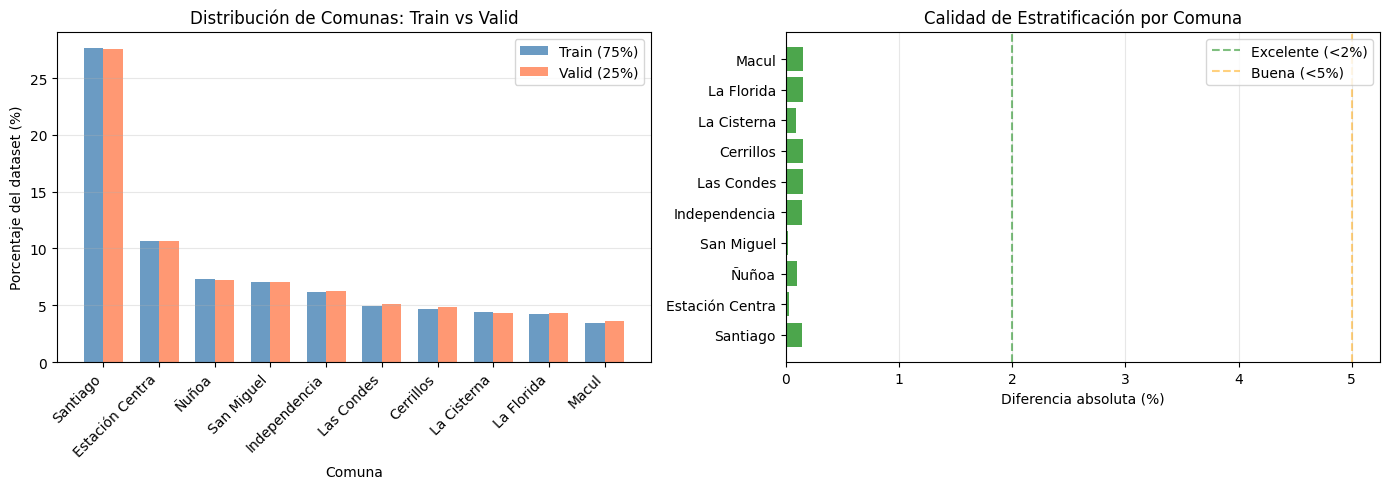


✓ Análisis de estratificación completado
✓ La división train/test mantiene proporciones similares por comuna


In [39]:
# ANÁLISIS DE ESTRATIFICACIÓN: Verificar distribución comuna entre Train/Test
import matplotlib.pyplot as plt

# Reconstruir índices de train/test para análisis
# Usando el random_state=42, podemos reconstruir la división
from sklearn.model_selection import train_test_split as tts_verify

_, _, _, _, idx_tr, idx_va = tts_verify(
    X_all, y_all, df_trainable.index,
    test_size=0.25, 
    random_state=42,
    stratify=df_trainable['comuna_estratificada']
)

# Análisis de distribución
comunas_train = df_trainable.loc[idx_tr, 'comuna_estratificada'].value_counts(normalize=True)
comunas_valid = df_trainable.loc[idx_va, 'comuna_estratificada'].value_counts(normalize=True)

print("=== ANÁLISIS DE ESTRATIFICACIÓN TRAIN/VALID ===\n")

# Comparar top 10 comunas
top_comunas = comunas_train.head(10).index

comparison_data = []
for comuna in top_comunas:
    pct_train = comunas_train.get(comuna, 0) * 100
    pct_valid = comunas_valid.get(comuna, 0) * 100
    diff = abs(pct_train - pct_valid)
    comparison_data.append({
        'Comuna': comuna,
        'Train %': pct_train,
        'Valid %': pct_valid,
        'Diferencia': diff
    })

df_comparison = pd.DataFrame(comparison_data)
print("Top 10 comunas - Distribución Train vs Valid:")
print(df_comparison.to_string(index=False))

# Métricas de estratificación
max_diff = df_comparison['Diferencia'].max()
mean_diff = df_comparison['Diferencia'].mean()

print(f"\n=== MÉTRICAS DE CALIDAD DE ESTRATIFICACIÓN ===")
print(f"Diferencia máxima: {max_diff:.2f}%")
print(f"Diferencia promedio: {mean_diff:.2f}%")

if mean_diff < 2.0:
    print("✓ EXCELENTE: Estratificación muy balanceada (<2% diferencia)")
elif mean_diff < 5.0:
    print("✓ BUENA: Estratificación balanceada (<5% diferencia)")
else:
    print("⚠️ ACEPTABLE: Estratificación con diferencias >5%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparación Train vs Valid
ax1 = axes[0]
x = range(len(top_comunas))
width = 0.35

train_values = [comunas_train.get(c, 0) * 100 for c in top_comunas]
valid_values = [comunas_valid.get(c, 0) * 100 for c in top_comunas]

ax1.bar([i - width/2 for i in x], train_values, width, label='Train (75%)', alpha=0.8, color='steelblue')
ax1.bar([i + width/2 for i in x], valid_values, width, label='Valid (25%)', alpha=0.8, color='coral')

ax1.set_xlabel('Comuna')
ax1.set_ylabel('Porcentaje del dataset (%)')
ax1.set_title('Distribución de Comunas: Train vs Valid')
ax1.set_xticks(x)
ax1.set_xticklabels([c[:15] for c in top_comunas], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: Diferencias absolutas
ax2 = axes[1]
diffs = df_comparison['Diferencia'].values
colors = ['green' if d < 2 else 'orange' if d < 5 else 'red' for d in diffs]

ax2.barh(range(len(top_comunas)), diffs, color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_comunas)))
ax2.set_yticklabels([c[:15] for c in top_comunas])
ax2.set_xlabel('Diferencia absoluta (%)')
ax2.set_title('Calidad de Estratificación por Comuna')
ax2.axvline(x=2, color='green', linestyle='--', alpha=0.5, label='Excelente (<2%)')
ax2.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='Buena (<5%)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de estratificación completado")
print("✓ La división train/test mantiene proporciones similares por comuna")

In [40]:
import numpy as np

mediana_uf = float(np.median(y_va))
mediana_clp = mediana_uf * valor_uf
mape = float(np.mean(np.abs((y_va - y_va_pred) / np.maximum(y_va, 1e-6))) * 100)

print(f"Mediana precio valid: {mediana_uf:.2f} UF (${mediana_clp:,.0f} CLP)")
print(f"MAPE: {mape:.2f}%  (error relativo promedio)")

Mediana precio valid: 9.33 UF ($370,000 CLP)
MAPE: 23.93%  (error relativo promedio)


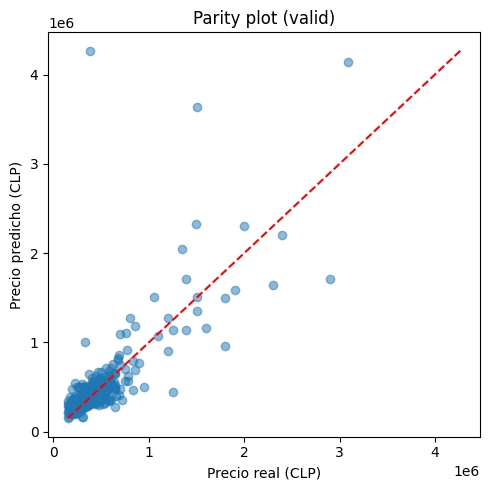

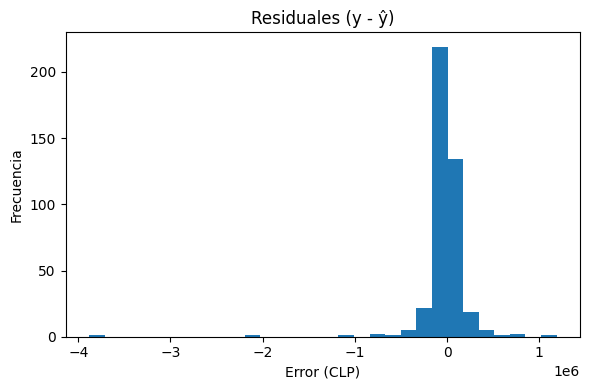

In [41]:
import matplotlib.pyplot as plt
resid = y_va - y_va_pred

# Convertir a CLP para visualización
y_va_clp = y_va * valor_uf
y_va_pred_clp = y_va_pred * valor_uf
resid_clp = resid * valor_uf

plt.figure(figsize=(5,5))
plt.scatter(y_va_clp, y_va_pred_clp, alpha=0.5)
mn, mx = min(y_va_clp.min(), y_va_pred_clp.min()), max(y_va_clp.max(), y_va_pred_clp.max())
plt.plot([mn,mx],[mn,mx],'--', color='red')
plt.xlabel("Precio real (CLP)")
plt.ylabel("Precio predicho (CLP)")
plt.title("Parity plot (valid)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid_clp, bins=30)
plt.title("Residuales (y - ŷ)")
plt.xlabel("Error (CLP)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import r2_score
y_tr_pred = rf.predict(X_tr)
print(f"R² train: {r2_score(y_tr, y_tr_pred):.3f}  |  R² valid: {r2:.3f}")

# Importancia de features
importancias = pd.DataFrame({
    'Feature': features,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nImportancia de variables:")
print(importancias)

R² train: 0.893  |  R² valid: 0.799

Importancia de variables:
            Feature  Importancia
1  superficie_total     0.490666
0   superficie_util     0.354015
3             banos     0.125139
2       dormitorios     0.030180


# MAPA DE CALOR GEOGRÁFICO

In [ ]:
# Mapa de calor con folium
import folium
from folium.plugins import HeatMap

# Calcular precio promedio por comuna (en CLP para visualización)
precio_comuna = df_arriendo.groupby('comuna')['precio'].mean().sort_values(ascending=False)

# Crear mapa centrado en Santiago
mapa = folium.Map(location=[-33.4489, -70.6693], zoom_start=11, tiles='CartoDB positron')

# Preparar datos para heatmap
heat_data = []
for comuna, precio_promedio in precio_comuna.items():
    if comuna in comunas_centroids and not pd.isna(precio_promedio):
        lat, lon = comunas_centroids[comuna]
        intensidad = min(precio_promedio / precio_comuna.max(), 1.0)
        heat_data.append([lat, lon, intensidad])
        
        # Info adicional
        info_comuna = datos_socioeconomicos.get(comuna, {})
        n_props = len(df_arriendo[df_arriendo['comuna']==comuna])
        
        popup_html = f"""
        <div style="font-family: Arial; width: 220px;">
            <h4 style="margin: 0 0 10px 0; color: #2c3e50;">{comuna}</h4>
            <p style="margin: 5px 0;"><b>Precio Promedio:</b> ${precio_promedio:,.0f}</p>
            <p style="margin: 5px 0;"><b>Propiedades:</b> {n_props}</p>
            <p style="margin: 5px 0;"><b>Ingreso medio:</b> ${info_comuna.get('ingreso_medio', 0):,.0f}</p>
            <p style="margin: 5px 0;"><b>Población:</b> {info_comuna.get('poblacion', 0):,}</p>
        </div>
        """
        
        # Color según precio
        if precio_promedio > precio_comuna.quantile(0.75):
            color = 'red'
        elif precio_promedio > precio_comuna.median():
            color = 'orange'
        else:
            color = 'green'
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            popup=folium.Popup(popup_html, max_width=250),
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7,
            weight=2
        ).add_to(mapa)

# Agregar heatmap
HeatMap(heat_data, radius=25, blur=35, 
        gradient={0.4: 'blue', 0.65: 'lime', 0.8: 'orange', 1.0: 'red'},
        min_opacity=0.3).add_to(mapa)

mapa.save('mapa_precios_santiago.html')
print("Mapa guardado en 'mapa_precios_santiago.html'")
mapa

Mapa guardado en 'mapa_precios_santiago.html'


In [ ]:
# Reentrenar con todo el set
rf_full = RandomForestRegressor(
    n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2
)
rf_full.fit(imp.fit_transform(df_trainable[features].values), y_all)

# Ejemplo de predicción con nuevas features
sup_util = 140.0
sup_total = sup_util * ratio_mediana if "superficie_total" in features else None

# Usar comuna de referencia (Providencia)
comuna_ref = 'Providencia'
lat_ref, lon_ref = comunas_centroids[comuna_ref]
dist_metro_ref = distancia_metro_mas_cercano(lat_ref, lon_ref)
ingreso_ref = datos_socioeconomicos[comuna_ref]['ingreso_medio']
pob_ref = datos_socioeconomicos[comuna_ref]['poblacion']

ejemplo = {}
for f in features:
    if f == "superficie_util":         ejemplo[f] = sup_util
    elif f == "superficie_total":      ejemplo[f] = sup_total
    elif f == "dormitorios":           ejemplo[f] = 4
    elif f == "banos":                 ejemplo[f] = 2
    elif f == "lat":                   ejemplo[f] = lat_ref
    elif f == "lon":                   ejemplo[f] = lon_ref
    elif f == "dist_metro_km":         ejemplo[f] = dist_metro_ref
    elif f == "ingreso_medio_comuna":  ejemplo[f] = ingreso_ref
    elif f == "poblacion_comuna":      ejemplo[f] = pob_ref

X_ex = imp.transform(pd.DataFrame([ejemplo], columns=features).values)
pred_uf = rf_full.predict(X_ex)[0]
pred_clp = pred_uf * valor_uf

print(f"Consulta: 4 dorm, 2 baños, 140 m² útil en {comuna_ref}")
print(f"Precio estimado: {pred_uf:.2f} UF (~${pred_clp:,.0f} CLP)")
print(f"Distancia al metro: {dist_metro_ref:.2f} km")
print(f"\nVector usado: {ejemplo}")

NameError: name 'RandomForestRegressor' is not defined